<a href="https://colab.research.google.com/github/senaccan/StyleGAN3/blob/main/GANs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# The process of connecting Google Drive to Colab - Google Drive'ı Colab'a bağlama süreci
from google.colab import drive
%tensorflow_version 2.x
drive.mount('/content/drive', force_remount=True)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Mounted at /content/drive


In [2]:
# We cloned the StyleGAN3 project from GitHub - StyleGAN3 projesini GitHub'dan kopyalama
!git clone https://github.com/NVlabs/stylegan3.git
!pip install ninja

Cloning into 'stylegan3'...
remote: Enumerating objects: 212, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 212 (delta 0), reused 1 (delta 0), pack-reused 207 (from 1)
Receiving objects: 100% (212/212), 4.16 MiB | 3.58 MiB/s, done.
Resolving deltas: 100% (101/101), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 18.8 MB/s eta 0:00:00


In [3]:
# Listing files and folders within the StyleGAN3 directory - StyleGAN3 dizinindeki dosya ve klasörleri listeleme
!ls /content/stylegan3

avg_spectra.py	 dnnlib      environment.yml  gui_utils    metrics	training       viz
calc_metrics.py  Dockerfile  gen_images.py    legacy.py    README.md	train.py
dataset_tool.py  docs	     gen_video.py     LICENSE.txt  torch_utils	visualizer.py


In [4]:
# Using pre-trained FFHQ 1024x1024 face image model from Nvidia - Nvidia'dan önceden eğitilmiş FFHQ 1024x1024 yüz görüntü modeli kullanma
!python /content/stylegan3/gen_images.py \
    --network=https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/versions/1/files/stylegan3-r-ffhq-1024x1024.pkl \
  --outdir=/content/results --seeds=6600-6625

Loading networks from "https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/versions/1/files/stylegan3-r-ffhq-1024x1024.pkl"...
Generating image for seed 6600 (0/26) ...
Setting up PyTorch plugin "bias_act_plugin"... /usr/local/lib/python3.10/dist-packages/torch/utils/cpp_extension.py:1964: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
Done.
Setting up PyTorch plugin "filtered_lrelu_plugin"... /usr/local/lib/python3.10/dist-packages/torch/utils/cpp_extension.py:1964: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
Done.
Generating image for seed 6601 (1/26) ...
Generating image for seed 6602 (2/26) ...
Generating image for seed 6603 (3/26) ...
Generating image for seed 6604 (4/26) ...
Gene

In [5]:
# The images generated using StyleGAN3 are saved and listed - StyleGAN3 kullanılarak oluşturulan görüntüleri kaydetme ve listeleme
!ls /content/results/

seed6600.png  seed6604.png  seed6608.png  seed6612.png	seed6616.png  seed6620.png  seed6624.png
seed6601.png  seed6605.png  seed6609.png  seed6613.png	seed6617.png  seed6621.png  seed6625.png
seed6602.png  seed6606.png  seed6610.png  seed6614.png	seed6618.png  seed6622.png
seed6603.png  seed6607.png  seed6611.png  seed6615.png	seed6619.png  seed6623.png


In [6]:
# copy files to folder
!cp /content/results/* \
    /content/drive/My\ Drive/projects/stylegan3

cp: target '/content/drive/My Drive/projects/stylegan3' is not a directory


In [7]:
import sys
sys.path.insert(0, "/content/stylegan3") # Adding the StyleGAN3 folder to Python's search path - StyleGAN3 klasörünü Python'ın arama yoluna ekleme
import pickle
import os
import numpy as np
import PIL.Image
from IPython.display import Image
import matplotlib.pyplot as plt
import IPython.display
import torch
import dnnlib
import legacy

# Generating a random vector in the latent space dimension - Latent space boyutunda rastgele bir vektör üretme
def seed2vec(G, seed):
  return np.random.RandomState(seed).randn(1, G.z_dim)

# The process of printing the image  - Görüntüyü yazdırma işlemi
def display_image(image):
  plt.axis('off')
  plt.imshow(image)
  plt.show()

# G = generatör
def generate_image(G, z, truncation_psi):
  # Render images for dlatents initialized from random seeds - Rastgele tohumlardan başlatılan dlatentler için görüntüleri işleme
    Gs_kwargs = {
        'output_transform': dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True),
        'randomize_noise': False
    }
    if truncation_psi is not None:
        Gs_kwargs['truncation_psi'] = truncation_psi

    label = np.zeros([1] + G.input_shapes[1][1:])
    images = G.run(z, label, **G_kwargs) # [minibatch, height, width, channel]
    return images[0]

# Assigns vectors according to whether the model is conditional or unconditional - Modelin koşullu, koşulsuz olmasına göre vektör atar
def get_label(G, device, class_idx):
  label = torch.zeros([1, G.c_dim], device=device)
  if G.c_dim != 0:
      if class_idx is None:
          ctx.fail('Must specify class label with --class when using a conditional network')
      label[:, class_idx] = 1
  else:
      if class_idx is not None:
          print ('warn: --class=lbl ignored when running on an unconditional network')
  return label

# Sending the latent vector (z) and labels to the GPU (device) - Latent vektörü (z) ve label'ları GPU'ya (device) gönderme
def generate_image(device, G, z, truncation_psi=1.0, noise_mode='const', class_idx=None):
  z = torch.from_numpy(z).to(device)
  label = get_label(G, device, class_idx)
  img = G(z, label, truncation_psi=truncation_psi, noise_mode=noise_mode)
  img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
  #PIL.Image.fromarray(img[0].cpu().numpy(), 'RGB').save(f'{outdir}/seed{seed:04d}.png')
  return PIL.Image.fromarray(img[0].cpu().numpy(), 'RGB')

In [8]:
#URL = "https://github.com/jeffheaton/pretrained-gan-fish/releases/download/1.0.0/fish-gan-2020-12-09.pkl"
#URL = "https://github.com/jeffheaton/pretrained-merry-gan-mas/releases/download/v1/christmas-gan-2020-12-03.pkl"
# The process of assigning a URL to a pre-trained weight file for NVIDIA's StyleGAN3 model - NVIDIA'nın StyleGAN3 modeli için önceden eğitilmiş ...
# ... bir ağırlık dosyasının URL'si atama işlemi
URL = "https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/versions/1/files/stylegan3-r-ffhq-1024x1024.pkl"

print(f'Loading networks from "{URL}"...')
device = torch.device('cuda')
with dnnlib.util.open_url(URL) as f:
    G = legacy.load_network_pkl(f)['G_ema'].to(device) # type: ignore


Loading networks from "https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/versions/1/files/stylegan3-r-ffhq-1024x1024.pkl"...


Seed 1005


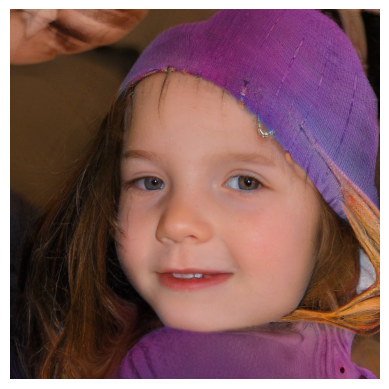

Seed 1006


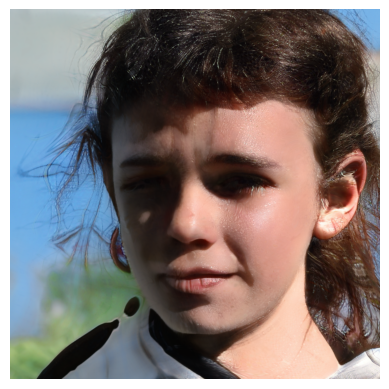

Seed 1007


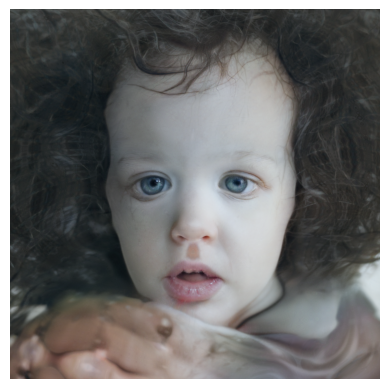

Seed 1008


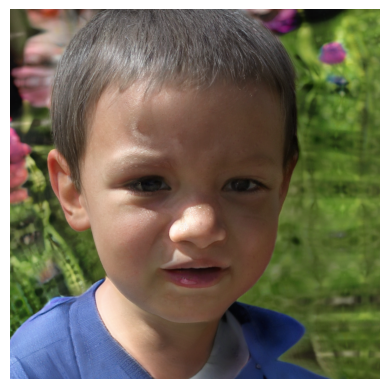

Seed 1009


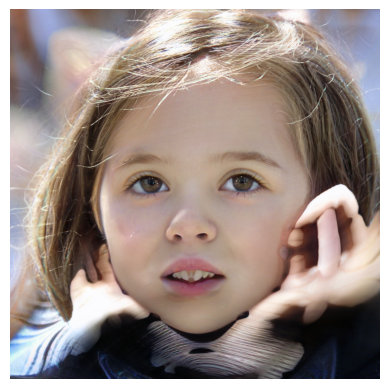

Seed 1010


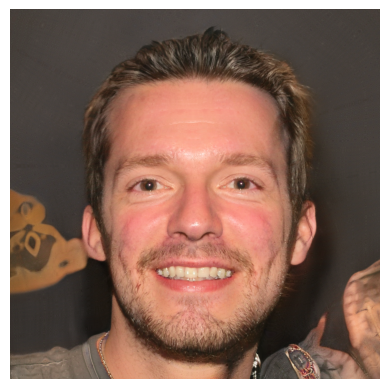

Seed 1011


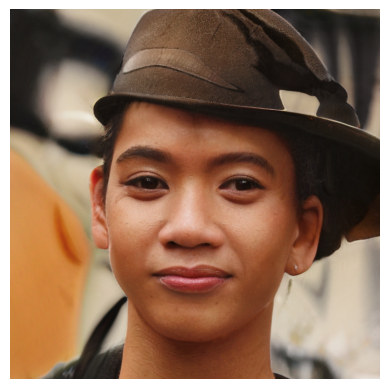

Seed 1012


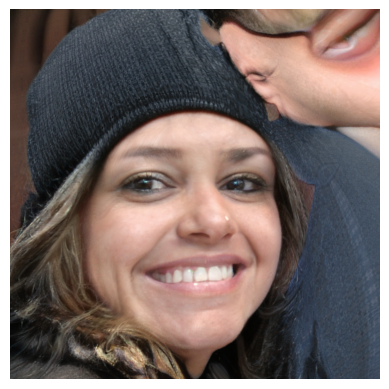

Seed 1013


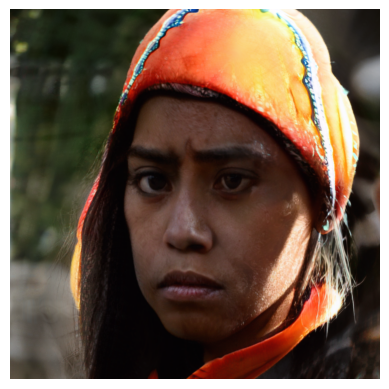

In [10]:
SEED_FROM = 1005
SEED_TO = 1014

for i in range(SEED_FROM, SEED_TO):
  print(f"Seed {i}")
  z = seed2vec(G, i)
  img = generate_image(device, G, z)
  display_image(img)